##  이제까지 만들었던 모델을 튜닝하고 배포하기!
Tuner 설치

In [1]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


## 그냥 실행시키면 에러나서 tensorflow upgrade 진행

In [2]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 w

## 0. 모델 고정해서 사용하기

이번 CIFAR10 프로젝트의 경우에는 모델을 고정해서 사용할 예정입니다. 모델의 경우에는 다음과 같은 그림으로 구성해주세요!

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Flatten, Dense, Dropout

model = Sequential([
    # 첫 번째 컨볼루션 블록
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    AveragePooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # 두 번째 컨볼루션 블록
    Conv2D(64, (3, 3), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # 플래튼 레이어
    Flatten(),

    # 완전 연결 레이어
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(10, activation='softmax') # 출력 클래스가 10개인 경우
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 15, 15, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 6, 6, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 612,426 (2.34 MB)

 Trainable params: 612,234 (2.34 MB)

 Non-trainable params: 192 (768.00 B)

## 1. Data Centric AI 맛보기

Data Centric AI를 공부했으니 한번 맛은 봐야겠죠? Data Centric AI를 정석적으로 진행한다면 훈련 데이터셋과 테스트 데이터셋을 전부 열어서 확인해서 틀린 것이 없는지 검수해야 합니다.
하지만 우리에게는 일일이 해볼만한 시간은 존재하지 않으니 사람들이 미리 검수했던 내용들을 기반으로 프로젝트를 진행하겠습니다.

    labelerrors.com

labelerrors.com은 Data Centric AI에서 가장 많이 활용하고 있는 파이썬 라이브러리인 cleanlab을 만든 개발자들이 공개한 사이트입니다. labelerrors.com은 이름에서 알 수 있듯이 테스트 데이터와 label이 잘못 붙어 있는 사례를 모아 보여줍니다.
labelerrors.com에서 CIFAR10 테스트 데이터셋을 확인하고 아래 조그맣게 있는 ID를 기준으로 직접 데이터셋을 시각화하고 실제 label이 잘못 붙어있다면 label을 수정해주세요.

In [5]:
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


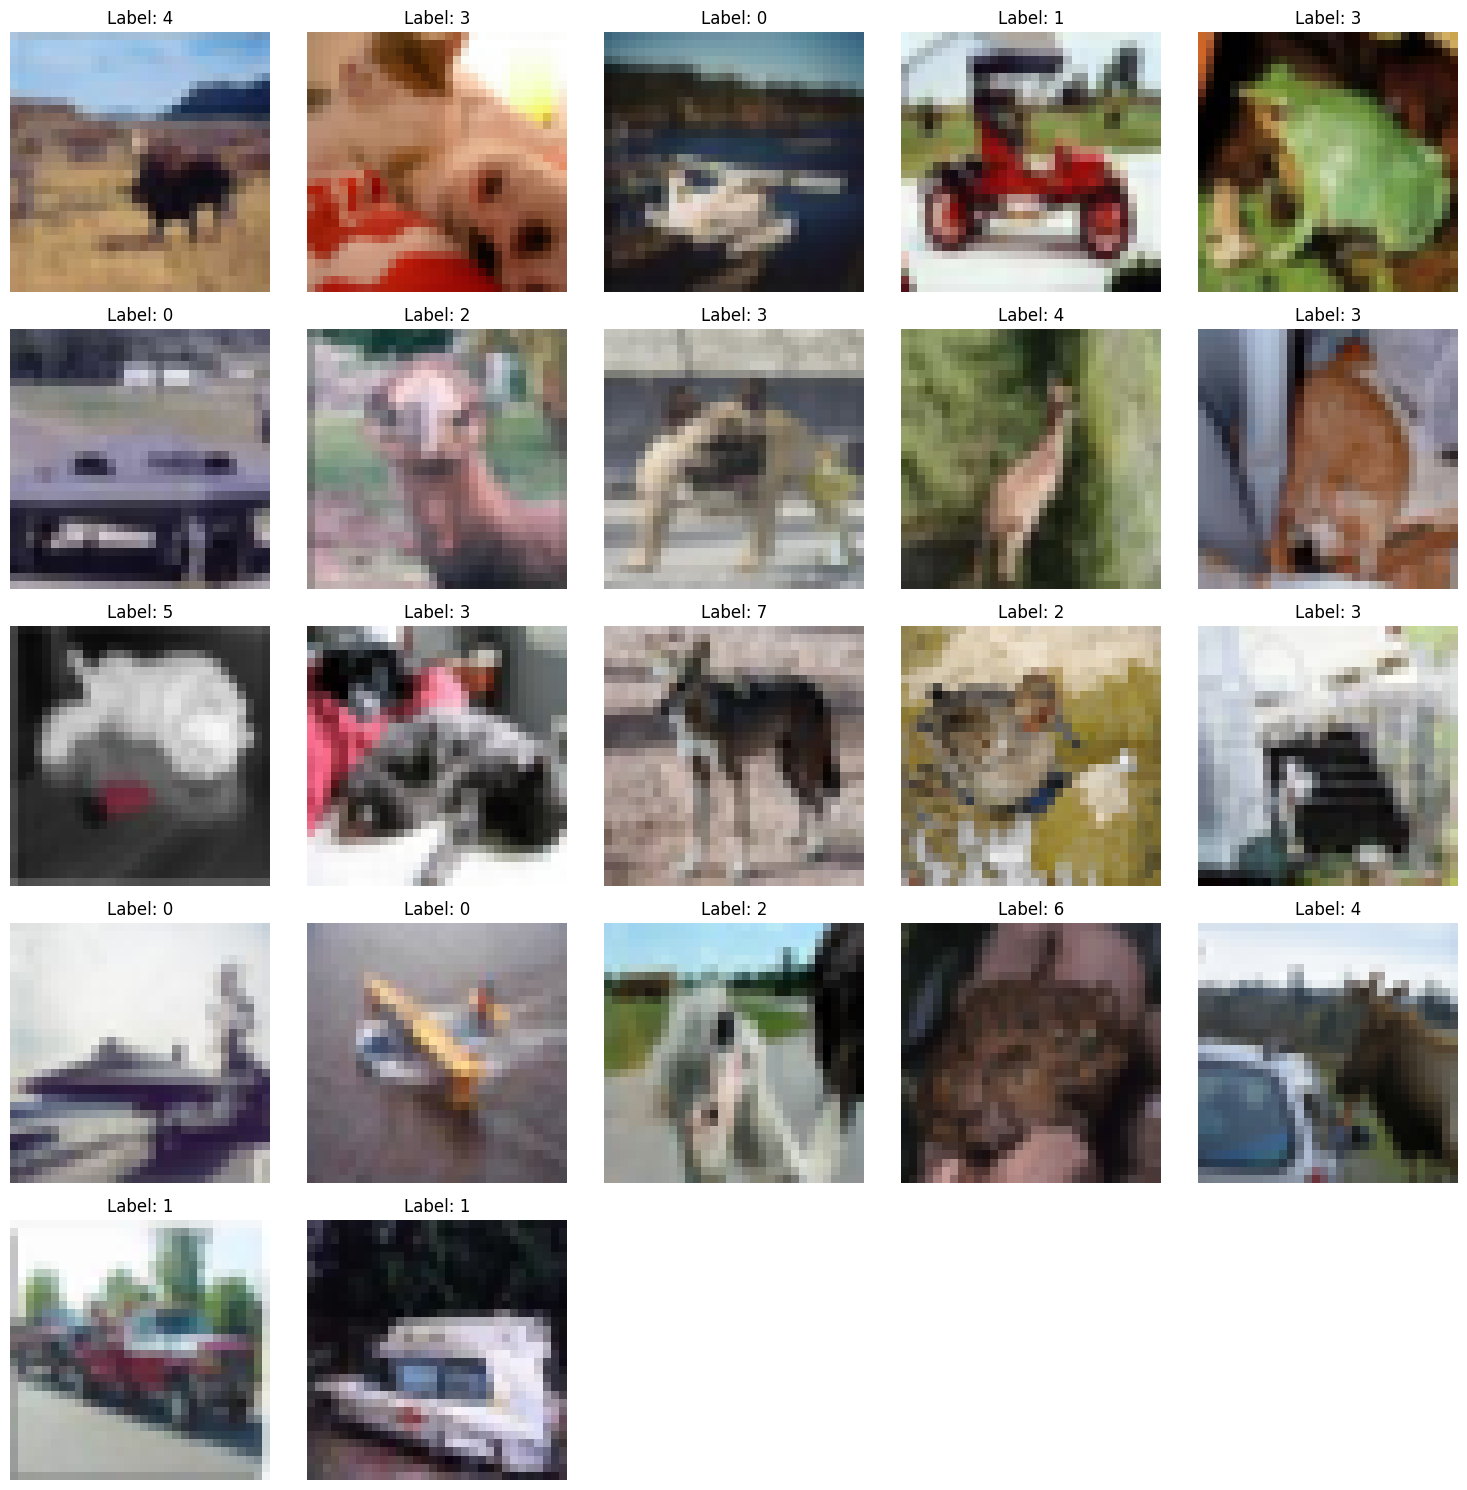

In [6]:
# CIFAR-10 데이터 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# ID 기반 시각화
def visualize_data(ids, images, labels):
    # 행과 열 계산
    total_images = len(ids)
    rows, cols = 5, 5  # 기본 그리드 크기
    max_plots = rows * cols

    # 서브플롯 생성
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    # 이미지 추가
    for ax, idx in zip(axes.ravel(), ids):
        ax.imshow(images[idx])
        ax.set_title(f"Label: {labels[idx][0]}")
        ax.axis('off')  # 축 제거

    # 빈 서브플롯 제거
    if total_images < max_plots:
        for ax in axes.ravel()[total_images:]:
            fig.delaxes(ax)  # 빈 subplot 제거

    # 레이아웃 정리
    plt.tight_layout()
    plt.show()

# 데이터 정의
data = [
    {"error_id": 165, "correct_label": 2},
    {"error_id": 1227, "correct_label": 5},
    {"error_id": 1718, "correct_label": 8},
    {"error_id": 1969, "correct_label": 9},
    {"error_id": 2405, "correct_label": 6},
    {"error_id": 2532, "correct_label": 1},
    {"error_id": 2592, "correct_label": 4},
    {"error_id": 2804, "correct_label": 5},
    {"error_id": 4794, "correct_label": 2},
    {"error_id": 5191, "correct_label": 5},
    {"error_id": 5468, "correct_label": 3},
    {"error_id": 5632, "correct_label": 5},
    {"error_id": 5690, "correct_label": 4},
    {"error_id": 5960, "correct_label": 3},
    {"error_id": 6792, "correct_label": 9},
    {"error_id": 6877, "correct_label": 8},
    {"error_id": 6966, "correct_label": 8},
    {"error_id": 7657, "correct_label": 7},
    {"error_id": 7846, "correct_label": 3},
    {"error_id": 8058, "correct_label": 7},
    {"error_id": 9227, "correct_label": 9},
    {"error_id": 9352, "correct_label": 9}
]

# error_ids 추출
error_ids = [item["error_id"] for item in data]

# 시각화
visualize_data(error_ids, x_test, y_test)

# 라벨 수정
for item in data:
    y_test[item["error_id"]] = item["correct_label"]


In [ ]:
'''
그밖에 실험
'''

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# cleanlab 설치
import subprocess
import sys
try:
    import cleanlab
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "cleanlab"])
    import cleanlab

In [ ]:
print("CIFAR-10 데이터 로드 중...")
# CIFAR-10 데이터 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("데이터 전처리 중...")
# 데이터 전처리
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train_flat = y_train.ravel()
y_test_flat = y_test.ravel()

# y를 원-핫 인코딩으로 변환
y_train_categorical = to_categorical(y_train, 10)
y_test_categorical = to_categorical(y_test, 10)

print("모델 정의 중...")
# CNN 모델 정의
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("모델 학습 중... (이 과정은 몇 분 정도 걸릴 수 있습니다)")

# 모델 학습
model.fit(x_train, y_train_categorical, batch_size=64, epochs=10, validation_split=0.1, verbose=1)




CIFAR-10 데이터 로드 중...
데이터 전처리 중...
모델 정의 중...
모델 학습 중... (이 과정은 몇 분 정도 걸릴 수 있습니다)
Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 79s 110ms/step - accuracy: 0.3027 - loss: 1.8855 - val_accuracy: 0.5598 - val_loss: 1.2822
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 80s 108ms/step - accuracy: 0.5045 - loss: 1.3739 - val_accuracy: 0.6070 - val_loss: 1.1193
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 111ms/step - accuracy: 0.5660 - loss: 1.2262 - val_accuracy: 0.6498 - val_loss: 1.0051
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 111ms/step - accuracy: 0.6064 - loss: 1.1243 - val_accuracy: 0.6718 - val_loss: 0.9433
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 110ms/step - accuracy: 0.6290 - loss: 1.0493 - val_accuracy: 0.6812 - val_loss: 0.9252
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 109ms/step - accuracy: 0.6471 - loss: 0.9976 - val_accuracy: 0.6914 - val_loss: 0.8913
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 87s 116ms/step - accuracy: 0.6688 - loss: 0.9438 - val_accuracy: 0.6974 - val_loss: 0.8693
Ep

테스트 데이터에 대한 예측 확률 계산 중...
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
cleanlab을 사용하여 라벨 에러 찾는 중...

ID	Current Label	Predicted Correct Label
4590	9		2
2059	9		8
6545	9		0
4106	3		8
1693	4		8
4036	7		0
1684	1		8
6510	4		9
1049	4		1
9225	5		0
1837	9		6
4942	5		0
4054	7		0
8972	9		2
1506	5		7
7004	3		0
139	9		9
2067	7		4
1713	8		1
3498	4		8
2486	7		4
9149	7		9

라벨 수정 완료!
라벨 에러 시각화 중...


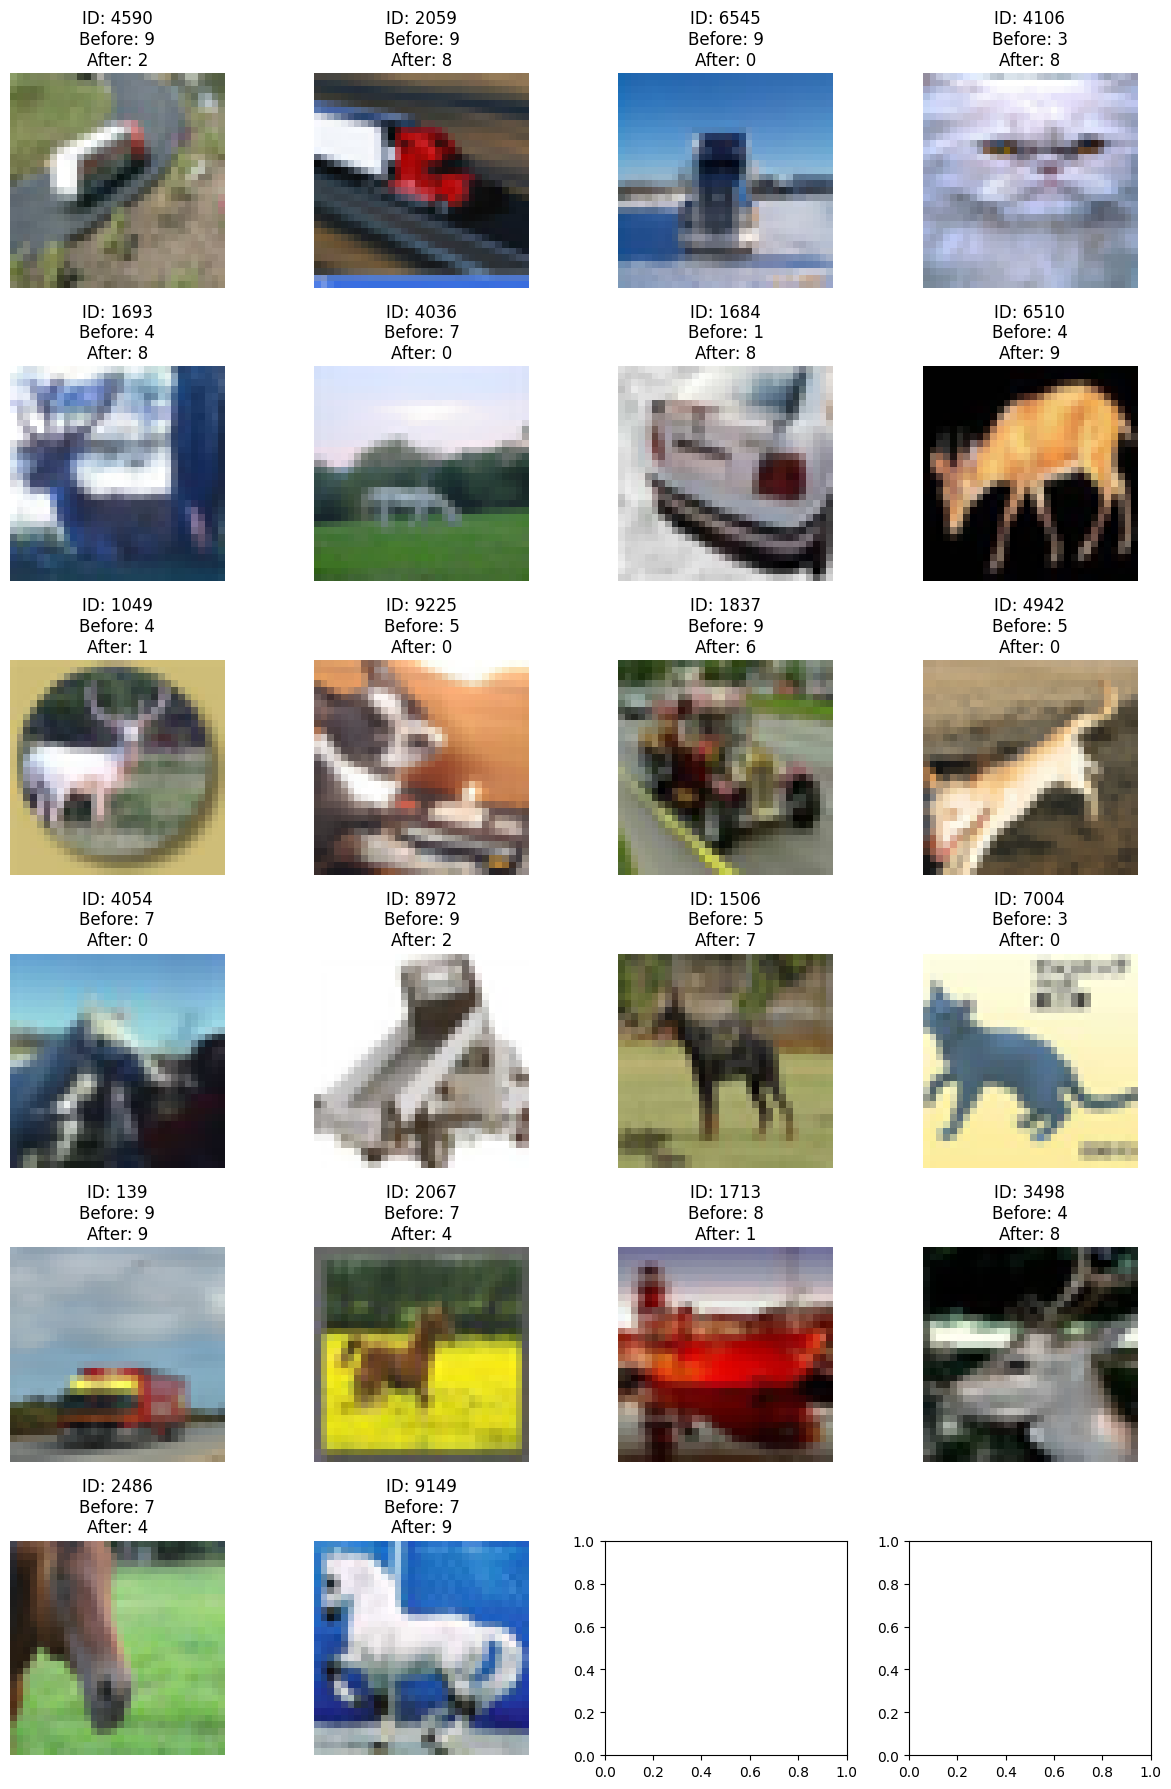

In [ ]:
print("테스트 데이터에 대한 예측 확률 계산 중...")
# 테스트 데이터에 대한 예측 확률 계산
pred_probs = model.predict(x_test)

print("cleanlab을 사용하여 라벨 에러 찾는 중...")
# cleanlab을 사용하여 라벨 에러 찾기

label_error_indices = cleanlab.filter.find_label_issues(
    labels=y_test_flat,
    pred_probs=pred_probs,
    return_indices_ranked_by='self_confidence'
)


# 상위 22개의 라벨 에러만 선택
top_errors = label_error_indices[:22]

# 각 에러 데이터의 ID, 현재 라벨, 예측된 올바른 라벨 출력
print("\nID\tCurrent Label\tPredicted Correct Label")
pred = np.argmax(pyx, axis=1)  # 예측 라벨
for idx in top_errors:
    current_label = y_test_flat[idx]
    predicted_label = pred[idx]
    print(f"{idx}\t{current_label}\t\t{predicted_label}")

# 라벨 수정
y_test_corrected = y_test.copy()
for idx in top_errors:
    y_test_corrected[idx][0] = pred[idx]

print("\n라벨 수정 완료!")

# 에러 데이터 시각화
def visualize_errors(ids, images, before_labels, after_labels):
    n = len(ids)
    rows = int(np.ceil(n / 4))
    cols = min(n, 4)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, idx in enumerate(ids):
        if i < len(axes):
            axes[i].imshow(images[idx])
            axes[i].set_title(f"ID: {idx}\nBefore: {before_labels[idx][0]}\nAfter: {after_labels[idx][0]}")
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("라벨 에러 시각화 중...")
# 라벨 에러 시각화
visualize_errors(top_errors, x_test, y_test, y_test_corrected)


# # 잘못된 라벨 ID
# error_ids = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468]  # labelerrors.com에서 확인한 ID
# visualize_data(error_ids, x_test, y_test)

# # 라벨 수정
# correct_labels = [6, 8, 7, 1, 7, 9, 5, 9, 5, 5, 4, 8, 4, 2, 3, 2, 9, 5, 9, 3, 8, 3]  # 수정할 라벨 값
# for i, idx in enumerate(error_ids):
#     y_test[idx] = correct_labels[i]


In [ ]:
# 라벨 수정
correct_labels = [6, 8, 7, 1, 7, 9, 5, 9, 5, 5, 4, 8, 4, 2, 3, 2, 9, 5, 9, 3, 8, 3]  # 수정할 라벨 값
for i, idx in enumerate(error_ids):
    y_test[idx] = correct_labels[i]

In [ ]:
'''
Tutorial - How To Find Label Errors With CleanLab.ipynb
https://github.com/cleanlab/label-errors/blob/main/examples/Tutorial%20-%20How%20To%20Find%20Label%20Errors%20With%20CleanLab.ipynb

https://arxiv.org/pdf/2103.14749

음.. 다시 한번

'''


import subprocess
import sys
try:
    import cleanlab
    print(f"cleanlab 버전: {cleanlab.__version__}")
except ImportError:
    print("cleanlab 설치 중...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "cleanlab"])
    import cleanlab
    print(f"cleanlab 버전: {cleanlab.__version__}")

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# matplotlib 설정 - 이미지 출력용
rc = {"axes.spines.left": False,
      "axes.spines.right": False,
      "axes.spines.bottom": False,
      "axes.spines.top": False,
      "xtick.bottom": False,
      "xtick.labelbottom": False,
      "ytick.labelleft": False,
      "ytick.left": False}
plt.rcParams.update(rc)

# CIFAR-10 클래스 이름 정의
CIFAR10_CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

print("="*30)
print("CIFAR-10 라벨 에러 분석")
print("="*30)

# CIFAR-10 데이터 로드
print("CIFAR-10 데이터셋 로드 중...")
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 데이터 전처리
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = y_train.flatten()
y_test = y_test.flatten()

# 모델 정의 및 학습 - 여기서는 간단한 CNN 사용
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# y를 원-핫 인코딩으로 변환
y_train_categorical = to_categorical(y_train, 10)

# 모델 정의
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
print("모델 학습 중...")
model.fit(x_train, y_train_categorical, batch_size=64, epochs=5, validation_split=0.1, verbose=1)

# 테스트 데이터에 대한 예측 확률 계산
print("테스트 데이터에 대한 예측 확률 계산 중...")
pred_probs = model.predict(x_test)

# 예측된 클래스 (argmax)
pred_labels = np.argmax(pred_probs, axis=1)

# cleanlab을 사용하여 라벨 에러 찾기
print(f"cleanlab을 사용하여 라벨 에러 찾는 중... (총 {len(y_test)} 개의 데이터, {len(CIFAR10_CLASSES)} 개의 클래스)")

# 버전에 따라 다른 API 사용
if hasattr(cleanlab, 'filter'):
    # 2.0 이상 버전의 API
    label_issues = cleanlab.filter.find_label_issues(
        labels=y_test,
        pred_probs=pred_probs,
        return_indices_ranked_by='self_confidence'
    )
    # 인덱스 배열로 변환
    label_error_indices = np.where(label_issues)[0] if isinstance(label_issues, np.ndarray) and label_issues.dtype == bool else label_issues
else:
    # 1.0 버전의 API
    label_error_indices = cleanlab.pruning.get_noise_indices(
        s=y_test,
        psx=pred_probs,
        sorted_index_method='self_confidence'
    )

num_errors = len(label_error_indices)
print(f'CIFAR-10 테스트셋에서 발견된 라벨 에러 개수: {num_errors}')

# 예측 모델의 confidence 계산 (예측된 클래스에 대한 확률)
pred_confidences = np.array([pred_probs[idx, pred_labels[idx]] for idx in label_error_indices])

# confidence 기준으로 정렬
sorted_indices = np.argsort(pred_confidences)[::-1]  # 내림차순 정렬
high_conf_error_indices = [label_error_indices[i] for i in sorted_indices]

# 상위 25개 에러만 출력 (confidence 높은 순)
top_n = min(25, num_errors)
top_errors = high_conf_error_indices[:top_n]

print(f"\n상위 {top_n}개 라벨 에러 (confidence 높은 순):")
print("ID\t현재 라벨\t예측 라벨\tConfidence(예측 클래스의 확률)")
for idx in top_errors:
    current_label = y_test[idx]
    predicted_label = pred_labels[idx]
    confidence = pred_probs[idx, predicted_label]  # 예측된 클래스의 confidence
    print(f"{idx}\t{CIFAR10_CLASSES[current_label]}\t{CIFAR10_CLASSES[predicted_label]}\t{confidence:.4f}")

# 라벨 에러 시각화
def visualize_errors(ids, images, labels, preds, pred_probs):
    if len(ids) == 0:
        print("시각화할 에러가 없습니다.")
        return

    n = len(ids)
    rows = (n + 4) // 5  # 한 행에 최대 5개 이미지
    cols = min(n, 5)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.reshape(-1) if hasattr(axes, 'reshape') else np.array([axes])

    for i, idx in enumerate(ids):
        if i < len(axes):
            # 테스트 이미지 출력
            axes[i].imshow(images[idx])
            conf = pred_probs[idx, preds[idx]]  # 예측된 클래스의 confidence
            axes[i].set_title(f"ID: {idx}\nLabel: {CIFAR10_CLASSES[labels[idx]]}\nPred: {CIFAR10_CLASSES[preds[idx]]}\nConf: {conf:.4f}")
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 에러 시각화 (confidence 높은 순 상위 25개)
print(f"\n라벨 에러 시각화 중... (confidence 높은 순 상위 {top_n}개)")
visualize_errors(top_errors, x_test, y_test, pred_labels, pred_probs)

# 전체 에러 목록 저장 (confidence 높은 순으로 정렬)
print(f"\n모든 라벨 에러 ID ({num_errors}개)를 confidence 순으로 'cifar10_label_errors.txt'에 저장합니다...")
with open('cifar10_label_errors.txt', 'w') as f:
    f.write("ID\t현재 라벨\t예측 라벨\tConfidence(예측 클래스의 확률)\n")
    for idx in high_conf_error_indices:
        current_label = y_test[idx]
        predicted_label = pred_labels[idx]
        confidence = pred_probs[idx, predicted_label]
        f.write(f"{idx}\t{CIFAR10_CLASSES[current_label]}\t{CIFAR10_CLASSES[predicted_label]}\t{confidence:.4f}\n")

print("\n분석 완료!")

# 라벨 수정
# y_test_corrected = y_test.copy()
# for idx in label_error_indices:
#     y_test_corrected[idx] = pred_labels[idx]

# print(f"\n라벨 수정 완료: 총 {num_errors}개의 라벨을 모델 예측값으로 수정했습니다.")

cleanlab 버전: 2.7.1
CIFAR-10 라벨 에러 분석
CIFAR-10 데이터셋 로드 중...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


모델 학습 중...
Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.3046 - loss: 1.8853 - val_accuracy: 0.5494 - val_loss: 1.2895
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.4965 - loss: 1.4102 - val_accuracy: 0.5878 - val_loss: 1.1603
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5464 - loss: 1.2724 - val_accuracy: 0.6362 - val_loss: 1.0502
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5808 - loss: 1.1636 - val_accuracy: 0.6484 - val_loss: 0.9991
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6098 - loss: 1.0996 - val_accuracy: 0.6580 - val_loss: 0.9531


KeyboardInterrupt: 

In [ ]:
'''
논문 살짝 읽어 보니 ... 그냥 간단한 cnn으로 해봐야 안 되는것 같다.
ResNet50 모델 사용/ 이미지 크기 조정 등등 ..

사전 학습된 모델로 걸러내보자 Go!! /
 결과 = > 무료 플랜이다보니 세션이 자꼬 다운됨. ㅠㅠ
로컬에서 셋팅 해봐야 할듯

'''

import subprocess
import sys

# 필요한 라이브러리 설치
for package in ['cleanlab', 'tensorflow', 'tensorflow-hub', 'numpy', 'matplotlib']:
    try:
        __import__(package)
    except ImportError:
        print(f"{package} 설치 중...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import cleanlab
import time

print(f"TensorFlow 버전: {tf.__version__}")
print(f"cleanlab 버전: {cleanlab.__version__}")

# matplotlib 설정 - 이미지 출력용
rc = {"axes.spines.left": False,
      "axes.spines.right": False,
      "axes.spines.bottom": False,
      "axes.spines.top": False,
      "xtick.bottom": False,
      "xtick.labelbottom": False,
      "ytick.labelleft": False,
      "ytick.left": False}
plt.rcParams.update(rc)

# CIFAR-10 클래스 이름 정의
CIFAR10_CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

print("="*50)
print("CIFAR-10 라벨 에러 분석 - ResNet 모델 사용")
print("="*50)

# CIFAR-10 데이터 로드
print("CIFAR-10 데이터셋 로드 중...")
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 데이터 전처리
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# CIFAR-10 이미지 크기를 ResNet의 입력 크기로 조정 (32x32 -> 224x224)
def resize_images(images, target_size=(224, 224)):
    resized_images = np.zeros((images.shape[0], target_size[0], target_size[1], 3))
    for i, img in enumerate(images):
        resized_images[i] = tf.image.resize(img, target_size).numpy()
    return resized_images

print("이미지 크기 조정 중...")
x_train_resized = resize_images(x_train)
x_test_resized = resize_images(x_test)

y_train = y_train.flatten()
y_test = y_test.flatten()

# y를 원-핫 인코딩으로 변환
y_train_categorical = to_categorical(y_train, 10)
y_test_categorical = to_categorical(y_test, 10)

# ResNet 모델 생성 (전이 학습)
def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # 상위 레이어만 훈련 가능하도록 설정
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 모델 생성
print("ResNet 모델 생성 중...")
model = create_resnet_model()
print(model.summary())

# 모델 학습
print("모델 학습 중... (몇 분 소요될 수 있습니다)")
start_time = time.time()

history = model.fit(
    x_train_resized, y_train_categorical,
    batch_size=32,
    epochs=10,
    validation_split=0.1,
    verbose=1
)

training_time = time.time() - start_time
print(f"학습 완료! 소요 시간: {training_time:.2f}초")

# 테스트 데이터에 대한 평가
test_loss, test_acc = model.evaluate(x_test_resized, y_test_categorical, verbose=1)
print(f"테스트 정확도: {test_acc:.4f}")

# 테스트 데이터에 대한 예측 확률 계산
print("테스트 데이터에 대한 예측 확률 계산 중...")
pred_probs = model.predict(x_test_resized)

# 예측된 클래스 (argmax)
pred_labels = np.argmax(pred_probs, axis=1)

# cleanlab을 사용하여 라벨 에러 찾기
print(f"cleanlab을 사용하여 라벨 에러 찾는 중...")

# cleanlab 버전에 따라 적절한 함수 사용
if hasattr(cleanlab, 'filter'):
    # cleanlab 2.0+ 버전
    label_issues = cleanlab.filter.find_label_issues(
        labels=y_test,
        pred_probs=pred_probs,
        return_indices_ranked_by='self_confidence'
    )
    label_error_indices = np.where(label_issues)[0] if isinstance(label_issues, np.ndarray) and label_issues.dtype == bool else label_issues
else:
    # cleanlab 1.0 버전
    label_error_indices = cleanlab.pruning.get_noise_indices(
        s=y_test,
        psx=pred_probs,
        sorted_index_method='self_confidence'
    )

num_errors = len(label_error_indices)
print(f'CIFAR-10 테스트셋에서 발견된 라벨 에러 개수: {num_errors}')

# 예측 모델의 confidence 계산 (예측된 클래스에 대한 확률)
pred_confidences = np.array([pred_probs[idx, pred_labels[idx]] for idx in label_error_indices])

# confidence 기준으로 정렬
sorted_indices = np.argsort(pred_confidences)[::-1]  # 내림차순 정렬
high_conf_error_indices = [label_error_indices[i] for i in sorted_indices]

# 상위 25개 에러만 출력 (confidence 높은 순)
top_n = min(25, num_errors)
top_errors = high_conf_error_indices[:top_n]

print(f"\n상위 {top_n}개 라벨 에러 (confidence 높은 순):")
print("ID\t현재 라벨\t예측 라벨\tConfidence")
for idx in top_errors:
    current_label = y_test[idx]
    predicted_label = pred_labels[idx]
    confidence = pred_probs[idx, predicted_label]  # 예측된 클래스의 confidence
    print(f"{idx}\t{CIFAR10_CLASSES[current_label]}\t{CIFAR10_CLASSES[predicted_label]}\t{confidence:.4f}")

# 라벨 에러 시각화
def visualize_errors(ids, images, labels, preds, pred_probs):
    if len(ids) == 0:
        print("시각화할 에러가 없습니다.")
        return

    n = len(ids)
    rows = (n + 4) // 5  # 한 행에 최대 5개 이미지
    cols = min(n, 5)

    plt.figure(figsize=(cols*3, rows*3))

    for i, idx in enumerate(ids):
        if i < n:
            plt.subplot(rows, cols, i+1)
            plt.imshow(images[idx])
            conf = pred_probs[idx, preds[idx]]  # 예측된 클래스의 confidence
            plt.title(f"ID: {idx}\nLabel: {CIFAR10_CLASSES[labels[idx]]}\nPred: {CIFAR10_CLASSES[preds[idx]]}\nConf: {conf:.4f}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# 원본 크기의 이미지로 에러 시각화 (confidence 높은 순 상위 25개)
print(f"\n라벨 에러 시각화 중... (confidence 높은 순 상위 {top_n}개)")
visualize_errors(top_errors, x_test, y_test, pred_labels, pred_probs)

# 전체 에러 목록 저장 (confidence 높은 순으로 정렬)
print(f"\n모든 라벨 에러 ID ({num_errors}개)를 confidence 순으로 'cifar10_label_errors.txt'에 저장합니다...")
with open('cifar10_label_errors.txt', 'w') as f:
    f.write("ID\t현재 라벨\t예측 라벨\tConfidence\n")
    for idx in high_conf_error_indices:
        current_label = y_test[idx]
        predicted_label = pred_labels[idx]
        confidence = pred_probs[idx, predicted_label]
        f.write(f"{idx}\t{CIFAR10_CLASSES[current_label]}\t{CIFAR10_CLASSES[predicted_label]}\t{confidence:.4f}\n")




cleanlab 설치 중...


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# 라벨 수정
y_test_corrected = y_test.copy()
for idx in label_error_indices:
    y_test_corrected[idx] = pred_labels[idx]

print(f"\n라벨 수정 완료: 총 {num_errors}개의 라벨을 모델 예측값으로 수정했습니다.")


# 수정된 라벨로 저장
np.save('cifar10_corrected_labels.npy', y_test_corrected)
print("수정된 라벨이 'cifar10_corrected_labels.npy'에 저장되었습니다.")

## 2. 하이퍼파라미터 튜닝

위에 있는 모델을 기반으로 KerasTuner로 하이퍼파라미터 튜닝을 진행합니다. 튜닝한 하이퍼 파라미터로 학습을 진행하고 모델을 SavedModel 형식으로 저장해주세요.

(주의사항)
하이퍼 파라미터를 어느정도 범위로 주는지에 따라서 모델 튜닝속도가 달라집니다.
학습시간을 고려해서 하이퍼 파라미터 튜닝을 세팅해주세요!

In [7]:
# 모델 정의 함수
def build_model(hp):
    model = Sequential([
        Conv2D(hp.Int('conv1_filters', min_value=16, max_value=64, step=16), (3, 3), activation='relu', input_shape=(32, 32, 3)),
        AveragePooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(hp.Int('conv2_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu'),
        AveragePooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'),
        Dropout(hp.Choice('dropout_rate', [0.2, 0.3, 0.5])),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # 시도할 모델의 개수
    executions_per_trial=2,  # 각 하이퍼파라미터 조합별 반복 횟수
    directory='cifar10_tuning',
    project_name='cifar10_project'
)

tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# 최적의 하이퍼파라미터 출력
best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"최적 필터 크기 1: {best_hps.get('conv1_filters')}")
print(f"최적 필터 크기 2: {best_hps.get('conv2_filters')}")
print(f"최적 드롭아웃 비율: {best_hps.get('dropout_rate')}")

Trial 5 Complete [00h 02m 55s]
val_accuracy: 0.7260499894618988

Best val_accuracy So Far: 0.7353500127792358
Total elapsed time: 00h 15m 34s
최적 필터 크기 1: 32
최적 필터 크기 2: 64
최적 드롭아웃 비율: 0.3


In [9]:

# 최적 하이퍼파라미터로 모델 생성 및 학습
model = tuner.hypermodel.build(best_hps)
model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

# 모델 저장
model.save('cifar10_saved_model.keras')

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.4511 - loss: 1.8276 - val_accuracy: 0.4863 - val_loss: 1.6419
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6701 - loss: 0.9349 - val_accuracy: 0.6329 - val_loss: 1.0457
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7406 - loss: 0.7378 - val_accuracy: 0.7015 - val_loss: 0.9003
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7910 - loss: 0.5936 - val_accuracy: 0.6782 - val_loss: 0.9556
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8378 - loss: 0.4625 - val_accuracy: 0.7186 - val_loss: 0.8501
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8723 - loss: 0.3673 - val_accuracy: 0.6898 - val_loss: 1.1746
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8980 - loss: 0.2938 - val_accuracy: 0.6935 - val_loss: 1.0773
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9113 - loss: 0.253

## 3. 모델 배포하기 (옵션)

하이퍼파라미터 튜닝을 끝낸 모델을 Docker 혹은 WSL2 환경에서 TFServing을 진행해 모델을 배포하세요! 모델 배포가 성공했다면 해당 코드쉘을 캡쳐해서 이미지를 주피터 노트북에 넣어주세요!

In [ ]:
## 해야하나??

## 4. TFLite 모델 만들기 (옵션)

여러분들이 만든 모델을 TFLite 모델로 만들어서 저장하고 서명을 확인하는 메소드까지 입력해주세요!

In [10]:
import tensorflow as tf

# HDF5 파일로 저장된 모델 로드
model = tf.keras.models.load_model('cifar10_saved_model.keras')

# TFLite 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# TFLite 파일 저장
with open('cifar10_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("TFLite 모델이 성공적으로 저장되었습니다!")

Saved artifact at '/tmp/tmpdke1et5i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  134669155090896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134669155092240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134669155091088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134669155092048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134669155097424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134669155092624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134669155093392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134669155091856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134669154591440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134669154594320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13466915509435

## 4. TFLite 모델 만들기 (옵션)

여러분들이 만든 모델을 TFLite 모델로 만들어서 저장하고 서명을 확인하는 메소드까지 입력해주세요!

In [11]:
# TFLite 모델 서명 확인
interpreter = tf.lite.Interpreter(model_path='cifar10_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("입력 텐서 정보:", input_details)
print("출력 텐서 정보:", output_details)

입력 텐서 정보: [{'name': 'serving_default_input_layer_1:0', 'index': 0, 'shape': array([ 1, 32, 32,  3], dtype=int32), 'shape_signature': array([-1, 32, 32,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
출력 텐서 정보: [{'name': 'StatefulPartitionedCall_1:0', 'index': 25, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


## (추가미션) 박찬성님의 TFX 프로젝트 분석해보기

https://d3s0tskafalll9.cloudfront.net/media/images/TFX.max-800x600.png

